# Prematch function in SLAT
You have a lot of ways to take use of prior, such as:

* Expert prior
* H&E images

In detail, if you have expert priors, you can rotate the slices so that they roughly align. If you have histological images of slices, you can be quickly aligned them via image registration tools such as [SimpleElastix](https://github.com/SuperElastix/SimpleElastix). Do not worry if you do not have above information, you always have cell locations in every dataset. SLAT provide a built-in method to do pre-match, which view cells in each slice as a point cloud and then the ICP (Iterative Closest Point) to register them.

You need following files as input:

 * merfish_layer1_labeled.h5ad
 * merfish_layer2_labeled.h5ad


In [1]:
import cv2
import numpy as np
import scanpy as sc
from matplotlib.pyplot import *
import matplotlib.pyplot
from matplotlib import pyplot as plt

from scSLAT.model.prematch import icp, alpha_shape, rotate_via_numpy

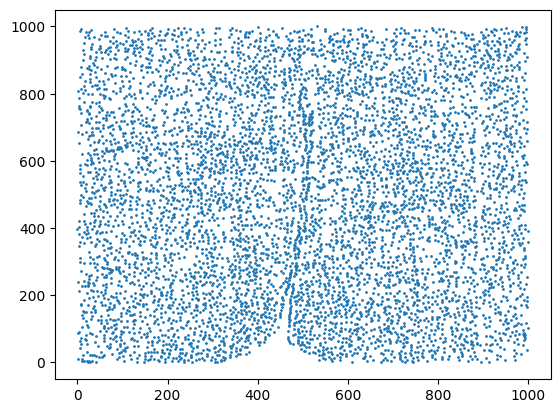

Rotation 40.10704565915762 degree


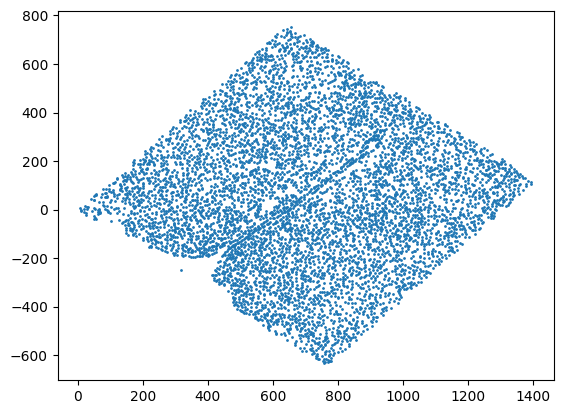

In [3]:
merfish1 = sc.read_h5ad('../../data/merfish/hypothalamic/merfish_layer1_labeled.h5ad')
spatial_info1 = merfish1.obsm['spatial']
plt.scatter(spatial_info1[:,0], spatial_info1[:,1], s=1)
plt.show()

merfish2 = sc.read_h5ad('../../data/merfish/hypothalamic/merfish_layer2_labeled.h5ad')
spatial_info2 = merfish2.obsm['spatial']
spatial_info2 = rotate_via_numpy(spatial_info2,0.7) # we rotate the cells coordinate in dataset 2
plt.scatter(spatial_info2[:,0], spatial_info2[:,1], s=1)
plt.show()

**alpha** is an important parameter in ICP. It means the step size in every iteration. A smaller step size will result in a more accurate alignment, but may converge to a local optimal solution, while a larger step size will reduce computation time, but the alignment may be less accurate. You can try different values to see the effect.

/tmp/ipykernel_3616393/3945006097.py:2: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  boundary_1, edges_1, _ = alpha_shape(spatial_info1, alpha=alpha, only_outer=True)


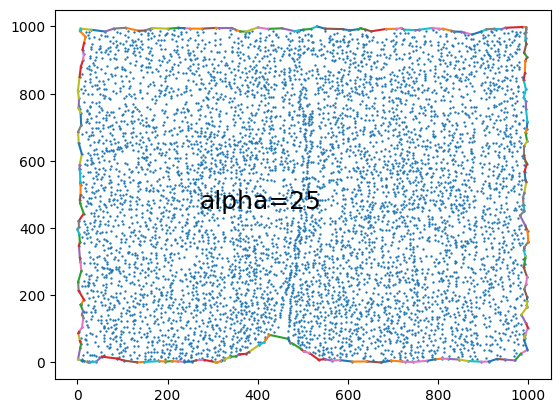

/tmp/ipykernel_3616393/3945006097.py:10: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  boundary_2, edges_2, _ = alpha_shape(spatial_info2, alpha=alpha, only_outer=True)


Text(270.5, 459, 'alpha=25')

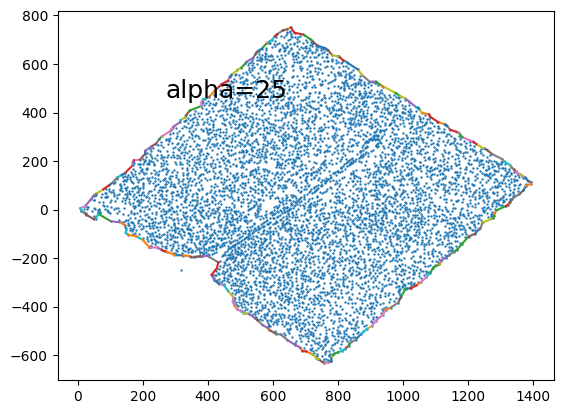

In [5]:
alpha = 25
boundary_1, edges_1, _ = alpha_shape(spatial_info1, alpha=alpha, only_outer=True)
plt.scatter(spatial_info1[:, 0], spatial_info1[:, 1], s = 0.5)
for i, j in edges_1:
    plt.plot(spatial_info1[[i, j], 0], spatial_info1[[i, j], 1])

plt.text(270.5,459, f"alpha={alpha}", size=18)
plt.show()

boundary_2, edges_2, _ = alpha_shape(spatial_info2, alpha=alpha, only_outer=True)
plt.scatter(spatial_info2[:, 0], spatial_info2[:, 1], s = 0.5)
for i, j in edges_2:
    plt.plot(spatial_info2[[i, j], 0], spatial_info2[[i, j], 1])

plt.text(270.5,459, f"alpha={alpha}", size=18)

Use ICP to register

In [6]:
T, error = icp(spatial_info2[boundary_2,:].T,spatial_info1[boundary_1,:].T)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)

src (1, 225, 2)
Tr[0:2] (2, 3)
T [[  0.75988392  -0.65005879   3.17847926]
 [  0.65005879   0.75988392 -13.56173822]
 [  0.           0.           1.        ]]
error 37571.443135075606
rotation° -40.54603416224576


At last we adjust the coordinates of dataset2, so two datasets have been pre-matched now! 

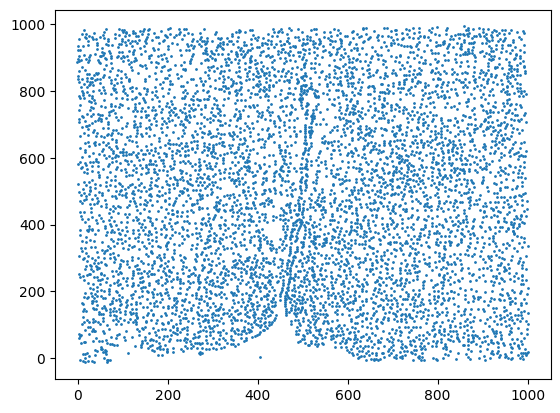

In [7]:
trans = np.squeeze(cv2.transform(np.array([spatial_info2], copy=True).astype(np.float32), T))[:,:2]
merfish2.obsm['spatial'] = trans
plt.scatter(trans[:,0], trans[:,1],s=1)
plt.show()